# Day 11, possibly dynamic programming?

This is a challenge that, to me, sounds like we need to use dynamic programming. For a large problem set, you'd only want to keep a running total. Since we want the top-left grid coordinate, you'd start at `(max(x), max(y))` and work your way backwards, taking advantage of the calculations already done for the `x + 1, y`, `x + 2, y`, `x, y + 1`, ..., `x + 2, y + 2` positions. For a 300 x 300 grid that would mean you only need to keep the last 600 calculation results in memory and let you use `max()` on the running calculation.

However, for a 300x300 grid it is simpler to just vectorise the hell out of the grid, using `numpy`.

The formula for any given grid coordinate power value is

$$\lfloor\frac{((x + 10)y + serial) \times (x + 10)}{100}\rfloor \bmod 10 - 5$$

but I must note that subtracting 5 at the end doesn't actually matter to the outcome. Either the cell score falls in the range $[0, 10)$ or $[-5, 5)$, with the 3 x 3 grid score in the range $[0, 81]$ or $[-45, 36]$. Not that `numpy` much cares.

Summing the sliding 3x3 windows is a little more interesting here. There are 298 x 298 complete 3 x 3 sub-grids that need to be considered here (from `((1, 1) ... (3, 3))` all the way to `((298, 298) ... (300, 300))`), and we need to create sums for all those sub windows. I'm using the [`numpy.lib.stride_tricks.as_strided()` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.stride_tricks.as_strided.html) here to step over the whole matrix in those 3x3 windows, so we can sum them all and produce a new `(298 x 298)` matrix of sums at coordinates that match the top-level corner of each sub-matrix.

In [1]:
from itertools import product
import numpy as np
from numpy.lib.stride_tricks import as_strided

# These values never change, so can be made globals
GRIDSIZE = 300
XX, YY = np.meshgrid(np.arange(1, GRIDSIZE + 1), np.arange(1, GRIDSIZE + 1))
RACK_ID = XX + 10

def grid_powers(serial):
    # calculate power levels
    return (RACK_ID * YY + serial) * RACK_ID // 100 % 10 - 5

def summed_grid_powers(power_levels, window_size=3):
    # sum levels for 3 x 3 subgrids; substitute edges for zeros
    
    window_count = GRIDSIZE - window_size + 1
    # output shape, 2d grid of 2d windows
    shape = (window_count, window_count, window_size, window_size)
    # per shape axis, the stride across power_levels matches up to the
    # same axes.
    strides = power_levels.strides * 2

    # we want to sum every subwindow, so it is time to start striding
    # we need to produce a (window_count, window_count, window_size, window_size)
    # matrix that then is summed on the last 2 axes.
    return as_strided(power_levels, shape, strides).sum(axis=(2, 3))
    
def max_grid(serial):    
    summed = summed_grid_powers(grid_powers(serial))

    # produce the (x, y) coordinates for the largest 3x3 grid top-left coordinate
    # argmax() flattens the array and gives us an index based on that, so we need
    # numpy.unravel to give back the original y, x coordinates.
    y, x = np.unravel_index(summed.argmax(), summed.shape)
    # Translate from zero to one-based indexing
    return x + 1, y + 1

In [2]:
power_tests = {
    # serial, x, y: power level
    (8, 3, 5): 4,
    (57, 122, 79): -5,
    (39, 217, 196): 0,
    (71, 101, 153): 4,
}

for (tserial, x, y), expected in power_tests.items():
    # indexing a [y, x] arranged matrix with 0-based offsets
    assert grid_powers(tserial)[y - 1, x - 1] == expected

max_tests = {
    18: (33, 45),
    42: (21, 61),
}

for tserial, expected in max_tests.items():
    assert max_grid(tserial) == expected

In [3]:
import aocd

data = aocd.get_data(day=11, year=2018)
serial = int(data)

In [4]:
x, y = max_grid(serial)
print(f'Part 1: {x},{y}')

Part 1: 44,37


In [5]:
%timeit grid_powers(serial)
%timeit max_grid(serial)

2.06 ms ± 98.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.97 ms ± 95.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Part 2, variable window size

Now I'm really glad I worked out how to do striding here. We can now produce separate summed matrices for each size. Vectorised sums over striding views does slow down dramatically in the middle somewhere, see timings below.

We still may want to explore dynamic programming here, however, as that would let us calculate values for all possible sizes as you traverse from 300, 300 down to 1,1 in one sweep. That's for later however.

In [6]:
%timeit grid_powers(serial)
power_levels = grid_powers(serial)
%timeit summed_grid_powers(power_levels)
%timeit summed_grid_powers(power_levels, 150)  # performance degrades
%timeit summed_grid_powers(power_levels, 300)  # performance degrades

2.02 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.78 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
218 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50.9 µs ± 376 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
def optimal_window_size(serial):
    power_levels = grid_powers(serial)
    # big matrix with 300 flattened power level arrays,
    # all padded back to 300 x 300 size so we can determine which one
    # has the most power output, then extract the size and grid position
    by_size = np.stack([
        np.pad(summed_grid_powers(power_levels, i + 1), (0, i), 'constant')
        for i in range(GRIDSIZE)
    ]).reshape(GRIDSIZE, -1)
    size = by_size.max(axis=1).argmax()
    y, x = np.unravel_index(by_size[size].argmax(), power_levels.shape)
    return x + 1, y + 1, size + 1

In [8]:
optimal_tests = {
    18: (90, 269, 16),
    42: (232, 251, 12),
}
for tserial, expected in optimal_tests.items():
    assert optimal_window_size(tserial) == expected

In [9]:
x, y, s = optimal_window_size(serial)
print(f'Part 2: {x},{y},{s}')

Part 2: 235,87,13


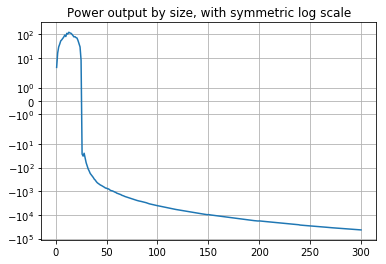

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.yscale('symlog')
plt.grid(True)
plt.title('Power output by size, with symmetric log scale')
power_levels = grid_powers(serial)
maxima = [summed_grid_powers(power_levels, i + 1).max() for i in range(300)]
_ = plt.plot(np.arange(1, len(maxima) + 1), maxima)